In [2]:
addprocs(4)
using SeisIO, HDF5, PyPlot, JUDI.TimeModeling, JUDI.SLIM_optim

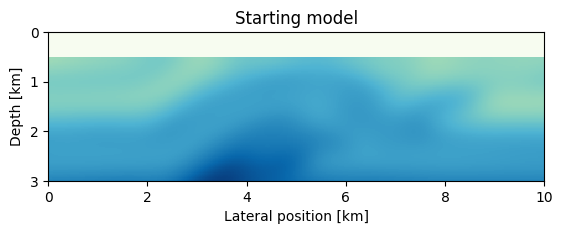

In [3]:
m0, n, d, o = read(h5open("overthrust_model.h5","r"),"m0","n","d","o"); title("Starting model")
model0 = Model((n[1],n[2]), (d[1],d[2]), (o[1],o[2]), m0);
imshow(sqrt.(1f0./m0)', cmap="GnBu", extent=(0,10,3,0));
xlabel("Lateral position [km]");
ylabel("Depth [km]");

In [4]:
block = segy_read("overthrust_shot_records.segy");
d_obs = judiVector(block);

In [5]:
println(typeof(d_obs))

JUDI.TimeModeling.judiVector{Float32}


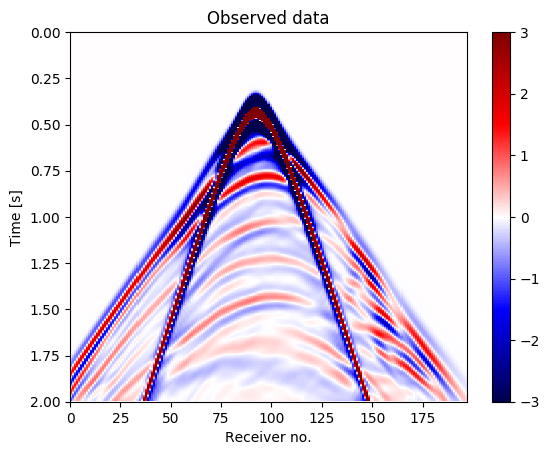

PyObject <matplotlib.text.Text object at 0x13bab1190>

In [15]:
imshow(d_obs.data[8], cmap="seismic", vmin=-3, vmax=3, extent=[0,size(d_obs.data[8],2),2,0]); 
ax1 = gca(); ax1[:set_aspect]("auto"); xlabel("Receiver no."); ylabel("Time [s]")
colorbar(); title("Observed data")

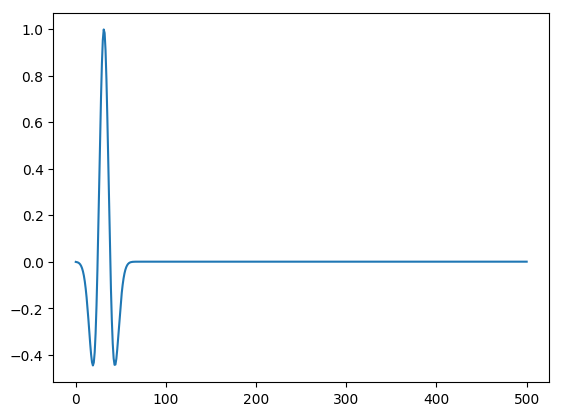

In [7]:
src_geometry = Geometry(block; key="source");
src_data = ricker_wavelet(src_geometry.t[1], src_geometry.dt[1], 0.008f0);
q = judiVector(src_geometry, src_data);
plot(q.data[1]);

In [8]:
ntComp = get_computational_nt(q.geometry, d_obs.geometry, model0);
info = Info(prod(model0.n), d_obs.nsrc, ntComp);

In [9]:
Ainv = judiModeling(info, model0);
Pr = judiProjection(info, d_obs.geometry);
Ps = judiProjection(info, q.geometry);

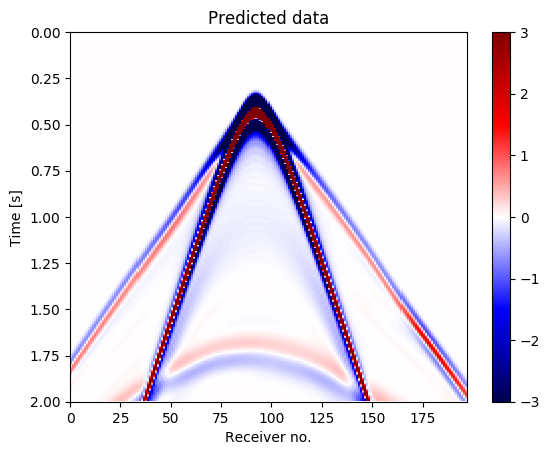

PyObject <matplotlib.text.Text object at 0x1253df150>

In [16]:
i = 8;
d_pred = Pr[i]*Ainv[i]*Ps[i]'*q[i];
imshow(d_pred.data[1], cmap="seismic", vmin=-3, vmax=3, extent=[0,size(d_obs.data[8],2),2,0]); 
ax1 = gca(); ax1[:set_aspect]("auto"); xlabel("Receiver no."); ylabel("Time [s]")
colorbar(); title("Predicted data")

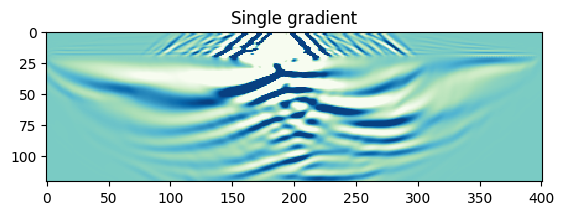

PyObject <matplotlib.text.Text object at 0x125097d10>

In [11]:
J = judiJacobian(Pr*Ainv*Ps',q);
#H_GN = J'*J    # Gauss-Newton Hessian
g = J[i]'*(d_pred - d_obs[i]);
imshow(reshape(g,model0.n)',vmin=-2e2,vmax=2e2, cmap="GnBu"); title("Single gradient")

This is a markdown cell $\mathbf{Ax} = \mathbf{b}$

In [17]:
# Set up bound constrains
v0 = sqrt.(1f0./model0.m)
vmin = ones(Float32, model0.n)*1.3f0;
vmax = ones(Float32, model0.n)*6.5f0;

# Fix water column
vmin[:,1:21] = v0[:,1:21];
vmax[:,1:21] = v0[:,1:21];

# Convert to squared slowness
mmin = vec((1f0./vmax).^2);
mmax = vec((1f0./vmin).^2);

** This example requires ~200 MB of memory per gradient, i.e. 800 MB with 4 parallel workers. It runs for approximately 15 minutes. **

In [18]:
maxiter = 10
batchsize = 8
proj(x) = reshape(median([vec(mmin) vec(x) vec(mmax)],2), model0.n)
fhistory = zeros(Float32,maxiter)

# Main loop
for j=1:maxiter
    println("Iteration: ",j)
    
    # get fwi objective function value and gradient
    i = randperm(d_obs.nsrc)[1:batchsize]
    fval, gradient = fwi_objective(model0, q[i], d_obs[i])
    fhistory[j] = fval

    # linesearch
    step = backtracking_linesearch(model0, q[i], d_obs[i], fval, gradient, proj; alpha=1f0)
    model0.m = proj(model0.m + reshape(step, model0.n))
    
end

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10


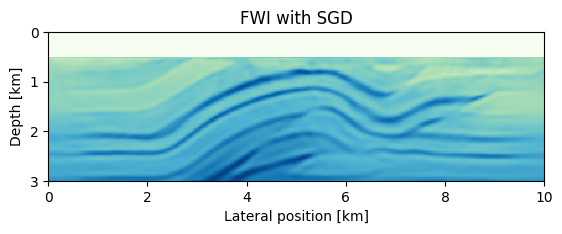

In [20]:
imshow(sqrt.(1f0./model0.m)', cmap="GnBu", extent=(0,10,3,0), vmin=1.5, vmax=5.4); title("FWI with SGD")
xlabel("Lateral position [km]");
ylabel("Depth [km]");

** DO NOT RUN. This example requires ~200 MB of memory per gradient, i.e. 800 MB with 4 parallel workers. It takes approximately 16 minutes per iteration and 2.5 hours for the full loop. **

In [ ]:
# Optimization parameters
using IterativeSolvers
model0.m = m0    # reset velocity model
maxiter_GN = 6
fhistory_GN = zeros(Float32,maxiter)

# Gauss-Newton method
for j=1:maxiter
    println("Iteration: ",j)

    # Model predicted data for subset of sources
    d_pred = Pr*Ainv*Ps'*q
    fhistory_GN[j] = .5f0*norm(d_pred - d_obs)^2
                        
    # GN update direction
    p = lsqr(J, d_pred - d_obs; maxiter=maxiter_GN, verbose=false)
                                                                                
    # update model and bound constraints
    model0.m = proj(model0.m - reshape(p, model0.n))    # alpha=1
end

Iteration: 1
Iteration: 2


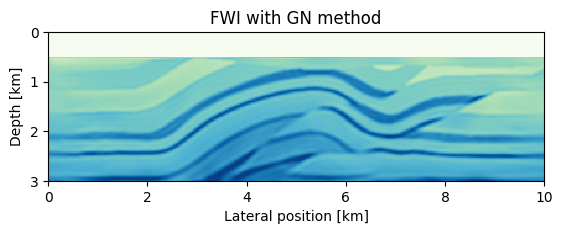

In [18]:
imshow(sqrt.(1f0./model0.m)', cmap="GnBu", extent=(0,10,3,0), vmin=1.5, vmax=5.4); title("FWI with GN method")
xlabel("Lateral position [km]");
ylabel("Depth [km]");

In [ ]:
fhistory_SG = fhistory/norm(fhistory,Inf)
fhistory_GN = fhistory_GN/norm(fhistory_GN,Inf)
plot(1:10, fhistory_SG, 1:10, fhistory_GN)
xlabel("Iteration no."); ylabel("Normalized function value")